In [1]:
import sys
sys.path.append("..")
from modules.utils import generate_matrix_close_to_isometry, generate_matrix_far_from_isometry, isometry_gap, ortho_gap
from modules.models import MLPWithBatchNorm, SinAct, CustomNormalization
from torch import nn
import torch
from torch.func import jacfwd
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib
import itertools
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
matplotlib.rcParams["figure.dpi"] = 80
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set(rc={"figure.dpi":80, 'savefig.dpi':80})
sns.set_theme()
sns.set_context('paper')
palette = sns.color_palette("tab10")
style = {"grid.linestyle": ":", 
        "border.color": "black",
       "axes.edgecolor": "black",
       "xtick.bottom": "True",
       "xtick.top": "True",
       "ytick.left": "True",
       "ytick.right": "True",
       "xtick.direction": "in",
       "ytick.direction": "in"}

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

d = 100
n = 100

root_dir = 'Data/'
train_set = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n, shuffle=True)
test_x, test_y = next(iter(train_loader))
test_x = test_x.cuda().flatten(1, -1)
test_y = test_y.cuda()

Files already downloaded and verified


In [27]:
'''
ds : dimensions
inits : initialization methods
act_names : activation function names 
depths : number of layers in the neural network
'''

ds = [50, 100, 250, 500]
inits = ['orthogonal']
act_names = ['identity']
depths = [500]
runs = list(itertools.product(*[inits, act_names, depths, ds]))

In [28]:
# Initialize an empty list to store experiment results.
df = []

C = 0.015  # A constant used in the calculation of the theoretical upper bound of isometry gap.

# Iterating over a predefined set of runs. 
# Each 'run' is a combination of initialization type, activation name, network depth, and dimension.
for run in tqdm(runs):
    init_type, act_name, L, d = run  # Unpacking the configuration for this run.
    n = d  # Number of samples, assuming it's equal to the dimension here.

    # Generate a perturbed identity matrix as test input.
    f = 0.005  # Perturbation factor.
    test_x = (1-f) * torch.eye(d).cuda() + f * (torch.rand(d).outer(torch.rand(d))).cuda()

    # Generate random test output labels.
    test_y = torch.randint(low=0, high=d, size=(n,)).cuda()

    # Calculate the initial isometry gap of the test input.
    ig0 = isometry_gap(test_x).item()
    print(ig0)

    # Perform multiple experiments for each configuration.
    for expi in range(10):
        # Get the activation function from a predefined dictionary of activations.
        activation = ACTIVATIONS[act_name]

        # Initialize the neural network model.
        model = MLPWithBatchNorm(input_dim=d, 
                                 output_dim=d, 
                                 num_layers=L, 
                                 hidden_dim=d, 
                                 norm_type='bn',
                                 bias=False,
                                 order='norm_act',
                                 force_factor=1.0,
                                 mean_reduction=False,
                                 activation=activation,
                                 exponent=0,
                                 save_hidden=True).cuda()

        # Reset the model parameters using the specified initialization type.
        model.reset_parameters(init_type, gain=GAINS[act_name])

        # Forward pass through the model.
        model.zero_grad()
        y_pred = model(test_x)
        outputs = model.hiddens

        # Analyze isometry gap at each layer of the network.
        for layer_num in range(L):
            # Compute the theoretical upper bound for the isometry gap.
            upperbound = ig0 * np.exp(-layer_num / (C * (d**2)*(1 + d*ig0)))

            # Calculate the isometry gap for the current layer's output.
            gap = isometry_gap(outputs[f'fc_{layer_num}']).item()

            # Append the results to the list.
            df.append({
                'isogap': gap,
                'Activation': act_name,
                'Initialization': init_type,
                'Layer': layer_num,
                'd': d,
                'upperbound': upperbound
            })

# Convert the list of results into a pandas DataFrame for analysis.
df = pd.DataFrame(df)


  0%|          | 0/4 [00:00<?, ?it/s]

0.00022190948948264122


 25%|██▌       | 1/4 [00:03<00:09,  3.17s/it]

0.000379219651222229


 50%|█████     | 2/4 [00:08<00:08,  4.37s/it]

0.0009585772641003132


 75%|███████▌  | 3/4 [01:42<00:45, 45.27s/it]

0.001996826846152544


100%|██████████| 4/4 [07:12<00:00, 108.17s/it]


In [29]:
edited_df = df.replace('orthogonal','Orthogonal').replace('xavier_normal', 'Normal')
edited_df = edited_df[edited_df['Activation'] == 'identity']
palette = sns.color_palette()
layers = np.arange(L)




In [30]:
img_name = 'iso_gap_default.pdf'

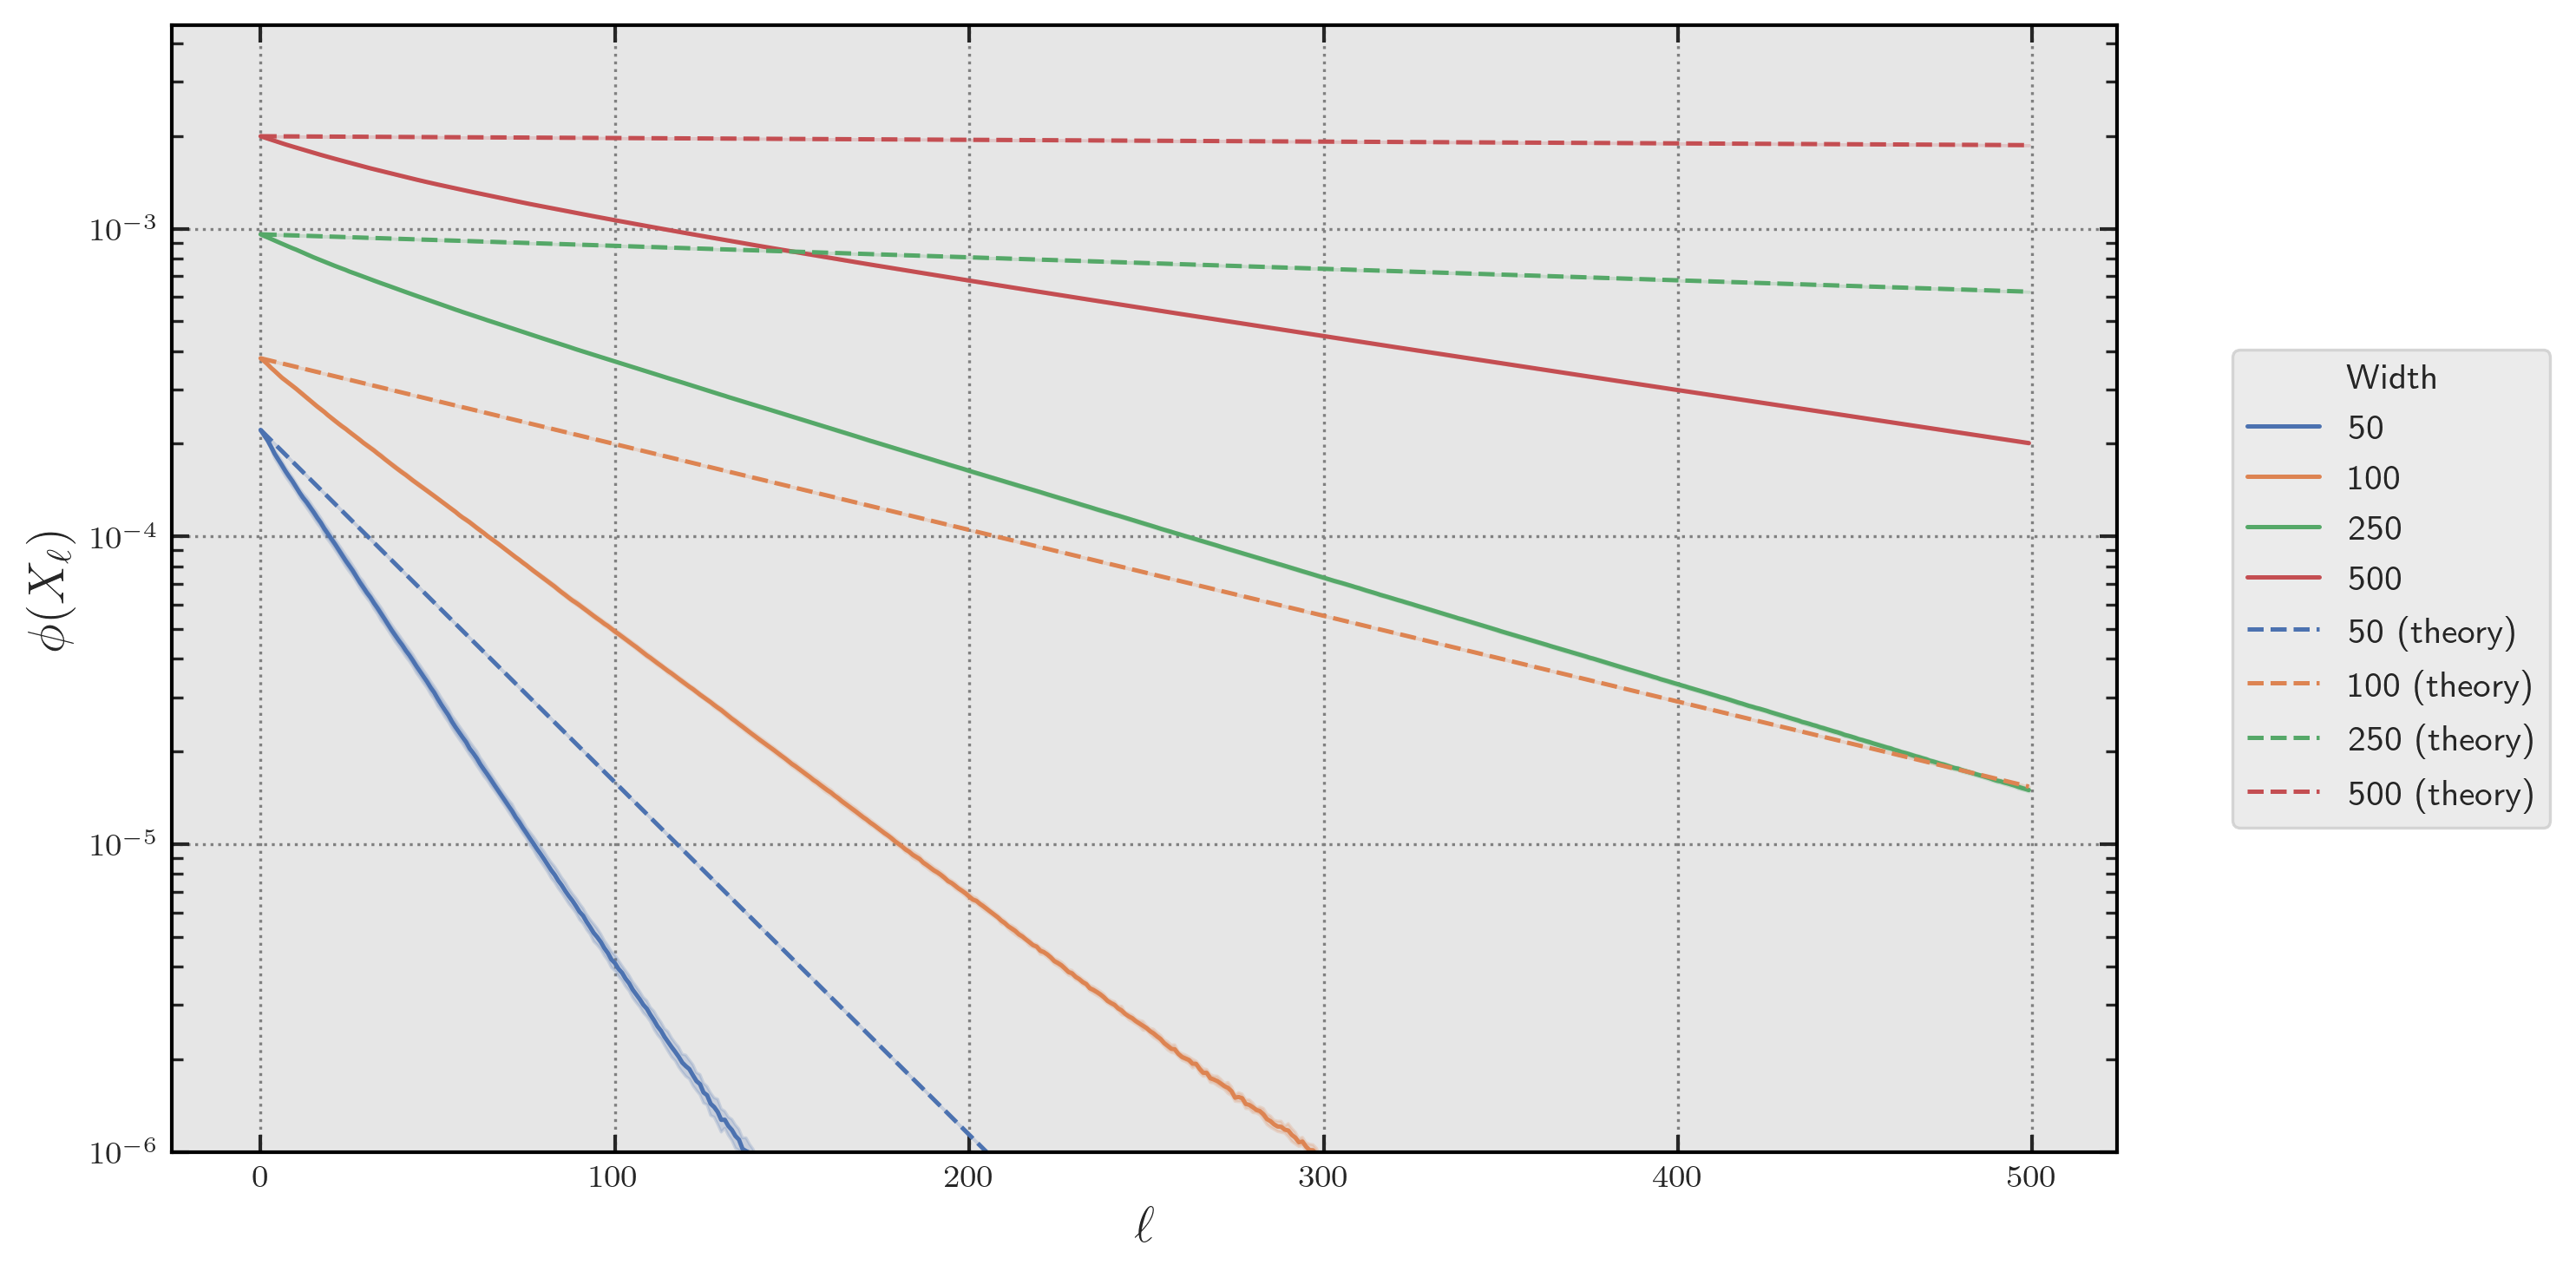

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'edited_df' is your DataFrame and 'palette' is a predefined color palette.
# Create a dictionary to map each 'd' value to a color.
unique_d_values = edited_df['d'].unique()
palette_dict = {d: color for d, color in zip(unique_d_values, sns.color_palette())}

sns.set_style('darkgrid', {'axes.facecolor': '0.9', 'grid.color': '.5', **style})

fig, ax = plt.subplots(dpi=300, figsize=(10, 5), ncols=1)

# Plotting the isogap as straight lines.
for d_value in unique_d_values:
    sns.lineplot(data=edited_df[edited_df['d'] == d_value], x='Layer', y='isogap', ax=ax, color=palette_dict[d_value], linestyle='-', legend=False)

# Plotting the upper bounds (theory lines) with dashed lines for all.
for d_value in unique_d_values:
    sns.lineplot(data=edited_df[edited_df['d'] == d_value], x='Layer', y='upperbound', ax=ax, color=palette_dict[d_value], linestyle='--', legend=False)

# Setting a logarithmic scale for the y-axis.
ax.set_yscale('log')

# Improving labels with larger font sizes and clearer notations.
ax.set_ylabel(r'$\phi(X_\ell)$', fontsize=14)
ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylim(bottom=1e-6)

# Reconstructing the legend to differentiate between isogap and upper bound lines.
isogap_handles = [plt.Line2D([0], [0], color=palette_dict[d], linestyle='-') for d in unique_d_values]
upperbound_handles = [plt.Line2D([0], [0], color=palette_dict[d], linestyle='--') for d in unique_d_values]
handles = isogap_handles + upperbound_handles
custom_labels = [f'{d}' for d in unique_d_values] + [f'{d} (theory)' for d in unique_d_values]
ax.legend(handles=handles, labels=custom_labels, frameon=True, title='Width', loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10)

fig.tight_layout()
plt.savefig('images/'+img_name)
plt.show()


<Figure size 512x384 with 0 Axes>